# Analizador de sentimientos para comentarios de películas utilizando Redes Neuronales y Word Embeddings

## Paso 1 - Lectura del conjunto de información

In [5]:
# Importar todas las librerías que se utilizarán
import pandas as pd 
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt


In [6]:
# Leemos el archivo y mostramos los primeros elementos para verificar
# que sean los correctos
movie_reviews = pd.read_csv("Reseñas de películas.csv")
# Verificar que no existan valore nulos
print("Existen valores nulos:")
print(movie_reviews.isnull().values.any())
movie_reviews.head(10)

Existen valores nulos:
False


,original,sentimiento,reseña
0,One of the other reviewers has mentioned that ...,positive,Uno de los otros críticos han mencionado que d...
1,A wonderful little production. <br /><br />The...,positive,Una producción pequeña y maravillosa. <br /> <...
2,I thought this was a wonderful way to spend ti...,positive,Pensé que esto era una maravillosa manera de p...
3,Basically there's a family where a little boy ...,negative,Básicamente hay una familia en la que un niño ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei de ""amor en los tiempos del dine..."
5,"Probably my all-time favorite movie, a story o...",positive,Probablemente mi película favorita de todos lo...
6,I sure would like to see a resurrection of a u...,positive,Estoy seguro que le gustaría ver una resurrecc...
7,"This show was an amazing, fresh & innovative i...",negative,"Este espectáculo fue una increíble, fresca y i..."
8,Encouraged by the positive comments about this...,negative,Alentados por los comentarios positivos sobre ...
9,If you like original gut wrenching laughter yo...,positive,Si te gusta la risa desgarradora original que ...


In [7]:
# Imprimimos uno de los ejemplos para revisar su escritura
movie_reviews["reseña"][5] # Algún número de ejemplo

'Probablemente mi película favorita de todos los tiempos, una historia de desinterés, sacrificio y dedicación a una causa noble, pero no es sermonear o aburrido. Simplemente nunca pasa de moda, a pesar de haber visto unas 15 veces o más en los últimos 25 años. rendimiento Paul Lukas\' trae lágrimas a mis ojos, y Bette Davis, en una de sus muy pocos papeles verdaderamente simpático, es una delicia. Los niños son, como dice la abuela, más como "enanos vestidos-up" que los niños, pero que sólo los hace más divertido de ver. Y lento despertar de la madre a lo que está pasando en el mundo y bajo su propio techo es creíble y sorprendente. Si tuviera una docena de los pulgares, todos estarían "arriba" para esta película.'

<BarContainer object of 2 artists>

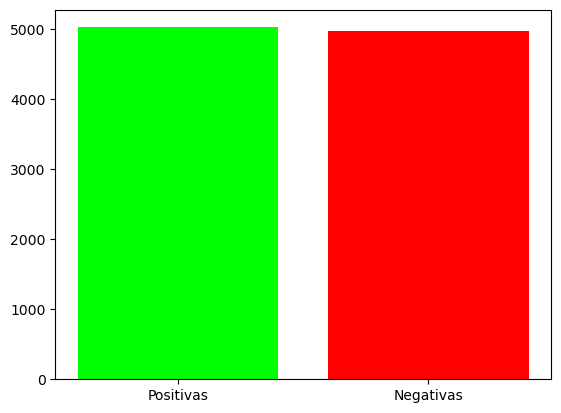

In [8]:
# Ver la distribución que tenemos de los datos 
Pos = 0
Neg = 0

for Sentiment in movie_reviews["sentimiento"]:
    if(Sentiment == 'positive'):
        Pos += 1
    else:
        Neg += 1

plt.bar(['Positivas', 'Negativas'], [Pos,Neg], color = ['lime', 'red'])

## Paso 2 - Preprocesamiento de la información

In [9]:
# Filtrado de StopWords utilizando NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words('spanish'))

X = []

removedor_tags = re.compile(r'<[^>]+>')

sentences = list(movie_reviews['reseña'])
for sen in sentences:
    
    # Filtrado de stopword (REEMPLAZAR la SW con nada)
    for stopword in stop_words:
        sentence = sen.replace(" " + stopword + " ", " ")

    # Remover los elementos de HTML (Que aparecen en los comentarios)
    sentence = removedor_tags.sub('', sentence)
    # Remover espacios múltiples
    sentence = re.sub(r'\s+', ' ', sentence)
    # Convertir todo a minúsculas
    sentence = sentence.lower()
    # Filtrado de signos de puntuación
    tokenizer = RegexpTokenizer(r'\w+')
    # Tokenización del resultado (Aplicando el rechazo de tokens descrito)
    result = tokenizer.tokenize(sentence)
    # Agregar al arreglo los textos "destokenizados" (Como texto nuevamente)
    X.append(TreebankWordDetokenizer().detokenize(result))

In [10]:
# Filtrado de más StopWords (Definidas por el usuario)
New_StopWords = ['a','acá','ahí','al','algo','algún','alguna','alguno','algunas','algunos','allá','allí','ambos','ante',
                 'antes','aquel','aquella','aquello','aquellas','aquellos','aquí','arriba','así','atrás','aun','aunque',
                 'bien','cada','casi','como','con','cual','cuales','cualquier','cualquiera','cuan','cuando','cuanto','cuanta',
                 'cuantos','cuantas','de','del','demás','desde','donde','dos','el','él','ella','ello','ellas','ellos','en',
                 'eres','esa','ese','eso','esas','esos','esta','esto','estas','estos','este','etc','ha','hasta','la','lo','las',
                 'los','me','mi','mis','mía','mías','mío','míos','mientras','muy','ni','nosotras','nosotros','nuestra',
                 'nuestro','nuestras','nuestros','os','otra','otro','otras','otros','para','pero','pues','que','qué','si','sí',
                 'siempre','siendo','sin','sino','so','sobre','sr','sra','sres','sta','su','sus','te','tu','tus','un','una',
                 'uno','unas','unos','usted','ustedes','vosotras','vosotros','vuestra','vuestro','vuestras','vuestros','y','ya',
                 'yo']

for i in range(len(X)):
    for element in New_StopWords:
        X[i] = X[i].replace(" " + str(element) + " ", " ")

print("Textos sin StopWords:")
X

Textos sin StopWords:


['uno críticos han mencionado después ver sólo 1 episodio oz estará enganchado tienen razón es exactamente sucedió conmigo primero llamó atención oz fue brutalidad escenas inquebrantable violencia conjunto derecha principio confía mí no es espectáculo débiles corazón o tímida espectáculo no tira golpes respecto drogas sexo o violencia es incondicional uso clásico palabra se llama oz es apodo dado estado penitentary oswald máxima seguridad se centra principalmente ciudad esmeralda sección experimental prisión todas células tienen frentes cristal cara hacia interior por privacidad no es prioridad agenda em city es hogar many aryans musulmanes gangstas latinos cristianos italianos irlandeses más por tanto enfrentamientos miradas muerte relaciones poco fiables acuerdos turbios nunca están lejos diría principal atractivo serie se debe hecho va espectáculos no se atreverían olvidar bonitos cuadros pintados por público mayoritario olvidar encanto olvidar romance oz no hace perder tiempo prime

## Paso 3 - Creación de vectores / matrices de entrada y salida para el entrenamiento

In [11]:
# Creación del vector objetivo (Postivo / Negativo)
Sent = movie_reviews['sentimiento']

y = []
for Sentimiento in Sent:
    # AGREGAR a la lista Y
    if Sentimiento == "positive":
        y.append(1)
    else:
        y.append(0)
print("Vector de objetivos:")
print(y)

Vector de objetivos:
[1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 

In [12]:
# Separación de la información en conjuntos de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Preparamos la capa de embeddingsn(Predefinimos una cantidad de
# 5000 palabras consideradas como tokens
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

# Transforma cada texto en una secuencia de valores enteros
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [13]:
# Conversión de los conjuntos de entrenamiento a vectores 
maxlen = 150

# Aquellos mayores a 100 son truncados, y los menores les 
# es replicado su último valor para tener arreglos
# bidimensionales del mismo tamaño (Usar el método para padding)
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print("Matriz de valores para las palabras:")
X_train.shape

Matriz de valores para las palabras:


(7999, 150)

In [14]:
# Verificar que la información de entrada sea coherente
print(X_train)
print(y_train)

[[ 169   16  602 ...    0    0    0]
 [ 434   81   20 ...    0    0    0]
 [3301  102 1196 ...    0    0    0]
 ...
 [1047   12 3853 ...    0    0    0]
 [  11 1427    4 ...  579 2716  766]
 [   2 1115  660 ...    0    0    0]]
[0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 

## Pasos 4 y 5 - Selección y aplicación del modelo de IA (DNN)

In [15]:
# Declaración de librerías para manejo de arreglos (Numpy)
from numpy import asarray
from numpy import zeros

# Lectura del archivo de embeddings
embeddings_dictionary = dict()
Embeddings_file = open('Word2Vect_Spanish.txt', encoding="utf8")

# Extraemos las características del archivo de embeddings
# y las agregamos a un diccionario (Cada elemento es un vextor)
for linea in Embeddings_file:
    caracts = linea.split()
    palabra = caracts[0]
    vector = asarray(caracts[1:], dtype='float32')
    embeddings_dictionary [palabra] = vector
Embeddings_file.close()

In [16]:
# Extraemos la cantidad de palabras en el vocabulario
vocab_size = len(tokenizer.word_index) + 1

# Generamos la matriz de embeddings (De entrada)
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    # Extraemos el vector de embedding para cada palabra
    embedding_vector = embeddings_dictionary.get(word)
    # Si la palbra si existía en el vocabulario
    # agregamos su vector de embeddings en la matriz
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [17]:
# Definimos las capas de nuestro modelo neuronal (DNN)
# Definimos que el modelo será secuencial (Y que ingresaremos cada capa en el orden de configuración de la red)
model = Sequential()
# Definimos los valores para nuestra capa de Embeddings
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)
# Agregamos al modelo 3 capas (La de Embeddings, una de aplanamiento y una Dense con activación Sigmoindal)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# Definimos métodos de optimización, que métrica se utilizará y como calcular la pérdida
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# Para ver la configuración que definimos
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 300)          16590600  
                                                                 
 flatten (Flatten)           (None, 45000)             0         
                                                                 
 dense (Dense)               (None, 1)                 45001     
                                                                 
Total params: 16,635,601


2023-09-28 11:57:19.105821: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Trainable params: 45,001
Non-trainable params: 16,590,600
_________________________________________________________________
None


In [18]:
# Utilizamos el método fit para ajustar los datos de nuestro modelo a la configuración que definimos
y_train_np = np.array(y_train)
X_train_np = np.array(X_train)
y_test_np = np.array(y_test)
X_test_np = np.array(X_test)

history = model.fit(X_train_np, y_train_np, batch_size=10, epochs=30, verbose=1, validation_split=0.2)
# Utilizamos evaluate para determinar la pérdida y el accuracy de nuestro modelo
score = model.evaluate(X_test_np, y_test_np, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/30
640/640 [==============================] - 3s 5ms/step - loss: 0.6228 - acc: 0.6495 - val_loss: 0.5599 - val_acc: 0.7144
Epoch 2/30
640/640 [==============================] - 3s 4ms/step - loss: 0.4083 - acc: 0.8576 - val_loss: 0.5222 - val_acc: 0.7544
Epoch 3/30
640/640 [==============================] - 2s 3ms/step - loss: 0.3021 - acc: 0.9283 - val_loss: 0.5215 - val_acc: 0.7475
Epoch 4/30
640/640 [==============================] - 2s 3ms/step - loss: 0.2344 - acc: 0.9562 - val_loss: 0.5189 - val_acc: 0.7462
Epoch 5/30
640/640 [==============================] - 2s 4ms/step - loss: 0.1885 - acc: 0.9728 - val_loss: 0.5128 - val_acc: 0.7487
Epoch 6/30
640/640 [==============================] - 3s 4ms/step - loss: 0.1496 - acc: 0.9856 - val_loss: 0.5260 - val_acc: 0.7381
Epoch 7/30
640/640 [==============================] - 2s 3ms/step - loss: 0.1226 - acc: 0.9914 - val_loss: 0.5295 - val_acc: 0.7481
Epoch 8/30
640/640 [==============================] - 2s 3ms/step - loss: 0.

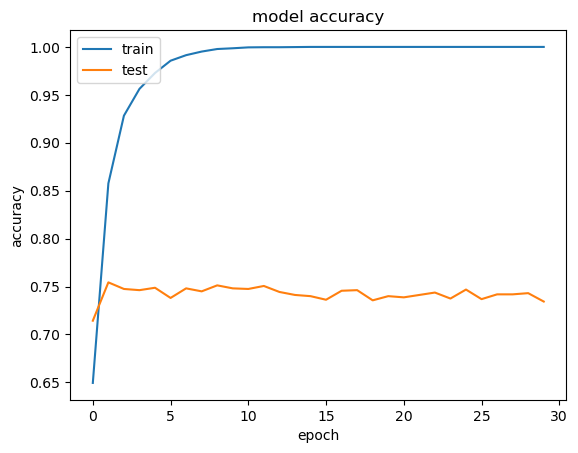

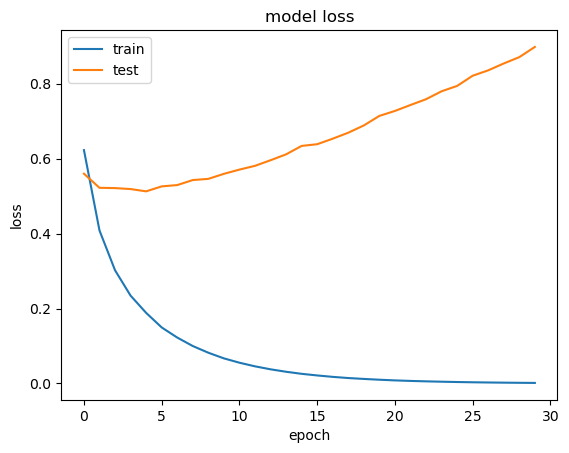

In [19]:
# Finalmente imprimimos la eficiencia y la pérdida del modelo
# época a época para ver su evolución
import matplotlib.pyplot as plt


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Paso 5.1 - Aplicación de una Red Convolucional (CNN) 

In [20]:
# Declaración de modelo Secuencial 
model = Sequential()

# Declaración de las capas del modelo convolucional
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Dense(64, activation='relu'))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
# Impresión de parámetros del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 300)          16590600  
                                                                 
 dense_1 (Dense)             (None, 150, 64)           19264     
                                                                 
 conv1d (Conv1D)             (None, 146, 128)          41088     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 16,651,081
Trainable params: 60,481
Non-trainable params: 16,590,600
_____________________________________

In [21]:
# Utilizamos el método fit para ajustar los datos de nuestro modelo a la configuración que definimos
history = model.fit(X_train_np, y_train_np, batch_size=10, epochs=30, verbose=1, validation_split=0.2)
# Utilizamos evaluate para determinar la pérdida y el accuracy de nuestro modelo
score = model.evaluate(X_test_np, y_test_np, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/30
640/640 [==============================] - 15s 22ms/step - loss: 0.5439 - acc: 0.7053 - val_loss: 0.4240 - val_acc: 0.8012
Epoch 2/30
640/640 [==============================] - 11s 17ms/step - loss: 0.3947 - acc: 0.8209 - val_loss: 0.3540 - val_acc: 0.8394
Epoch 3/30
640/640 [==============================] - 11s 18ms/step - loss: 0.3264 - acc: 0.8587 - val_loss: 0.3303 - val_acc: 0.8594
Epoch 4/30
640/640 [==============================] - 14s 21ms/step - loss: 0.2732 - acc: 0.8869 - val_loss: 0.3692 - val_acc: 0.8344
Epoch 5/30
640/640 [==============================] - 14s 21ms/step - loss: 0.2286 - acc: 0.9086 - val_loss: 0.3228 - val_acc: 0.8619
Epoch 6/30
640/640 [==============================] - 12s 19ms/step - loss: 0.1775 - acc: 0.9317 - val_loss: 0.3416 - val_acc: 0.8581
Epoch 7/30
640/640 [==============================] - 15s 23ms/step - loss: 0.1416 - acc: 0.9517 - val_loss: 0.3460 - val_acc: 0.8569
Epoch 8/30
640/640 [==============================] - 14s 22ms

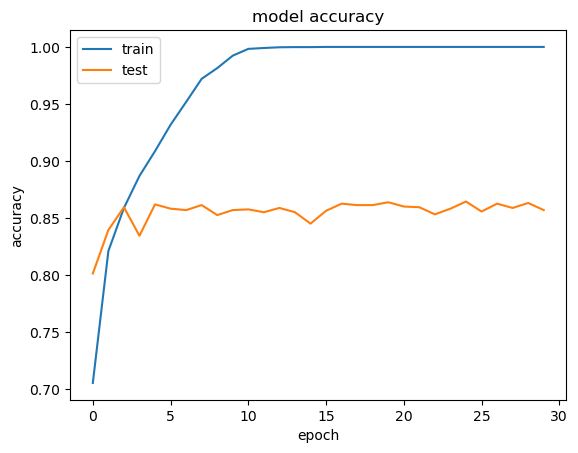

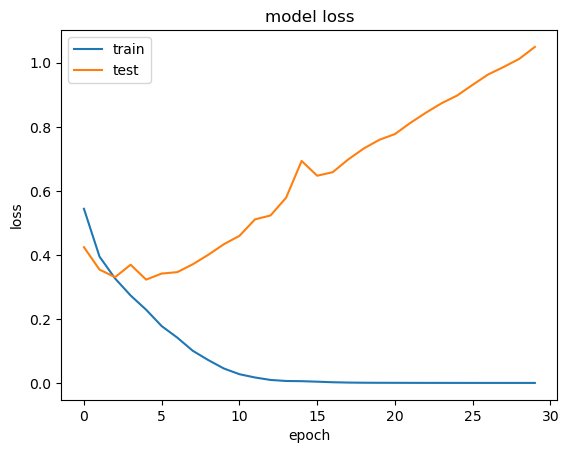

In [22]:
# Finalmente imprimimos la eficiencia y la pérdida del modelo
# época a época para ver su evolución
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Paso 5.2 - Red LSTM

In [23]:
# Declaración de modelo Secuencial 
model = Sequential()

# Declaración de las capas del modelo LSTM
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=True)
model.add(embedding_layer)
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Impresión de parámetros del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 300)          16590600  
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,684,105
Trainable params: 16,684,105
Non-trainable params: 0
_________________________________________________________________
None


2023-09-28 12:05:09.080448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-28 12:05:09.081739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-28 12:05:09.082750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [24]:
# Utilizamos el método fit para ajustar los datos de nuestro modelo a la configuración que definimos
history = model.fit(X_train_np, y_train_np, batch_size=10, epochs=10, verbose=1, validation_split=0.2)
# Utilizamos evaluate para determinar la pérdida y el accuracy de nuestro modelo
score = model.evaluate(X_test_np, y_test_np, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/10


2023-09-28 12:05:09.388197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-28 12:05:09.390035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-28 12:05:09.391298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

640/640 [==============================] - ETA: 0s - loss: 0.6767 - acc: 0.5756

2023-09-28 12:07:52.856893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-28 12:07:52.858277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-28 12:07:52.859350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

640/640 [==============================] - 169s 260ms/step - loss: 0.6767 - acc: 0.5756 - val_loss: 0.6845 - val_acc: 0.5512
Epoch 2/10
640/640 [==============================] - 162s 254ms/step - loss: 0.6188 - acc: 0.6353 - val_loss: 0.6716 - val_acc: 0.5450
Epoch 3/10
640/640 [==============================] - 167s 260ms/step - loss: 0.5106 - acc: 0.7396 - val_loss: 0.5279 - val_acc: 0.7881
Epoch 4/10
640/640 [==============================] - 177s 277ms/step - loss: 0.3758 - acc: 0.8436 - val_loss: 0.4560 - val_acc: 0.8181
Epoch 5/10
640/640 [==============================] - 188s 294ms/step - loss: 0.2240 - acc: 0.9164 - val_loss: 0.4276 - val_acc: 0.8338
Epoch 6/10
640/640 [==============================] - 157s 245ms/step - loss: 0.1107 - acc: 0.9661 - val_loss: 0.4987 - val_acc: 0.8400
Epoch 7/10
640/640 [==============================] - 162s 253ms/step - loss: 0.0570 - acc: 0.9861 - val_loss: 0.6283 - val_acc: 0.8338
Epoch 8/10
640/640 [==============================] - 165s 

2023-09-28 12:33:03.204983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-28 12:33:03.206374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-28 12:33:03.207354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - 4s 50ms/step - loss: 0.7093 - acc: 0.8390
Test Score: 0.7092686295509338
Test Accuracy: 0.8389999866485596


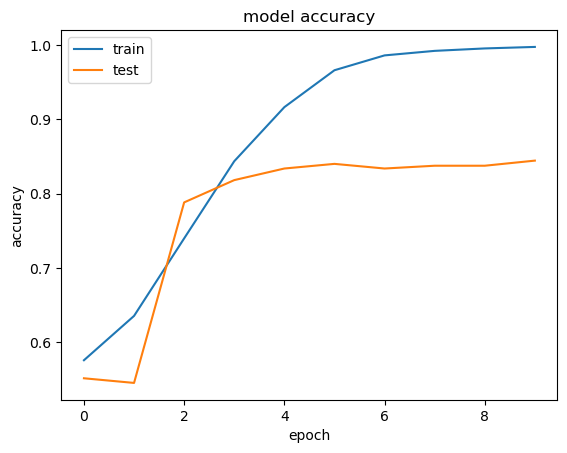

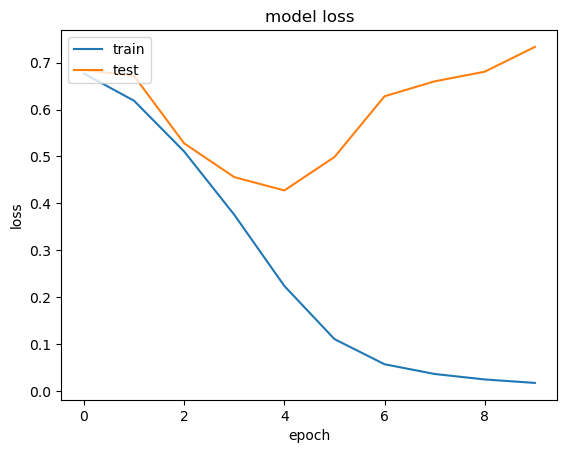

In [25]:
# Finalmente imprimimos la eficiencia y la pérdida del modelo
# época a época para ver su evolución
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Paso 6 - Probar el modelo

In [26]:
def Instancer(inp):  
    inp = inp.lower()
    inp = inp.replace("á", "a")
    inp = inp.replace("é", "e")
    inp = inp.replace("í", "i")
    inp = inp.replace("ó", "o")
    inp = inp.replace("ú", "u")
    inp = inp.replace("¿", "")
    inp = inp.replace("?", "")
    txt = [inp]
    seq = tokenizer.texts_to_sequences(txt)
    padded = pad_sequences(seq, maxlen=maxlen)
    return padded

In [27]:
#utterance = "Acabo de terminar esta película la vi en el estante de videos y, siendo fan de Nick Stahl, tuve que alquilarla. Con toda honestidad, probablemente debería haberse quedado en el estante. El concepto era interesante y hubo varios giros y vueltas bastante inteligentes, pero de alguna manera adiviné casi todos antes de que aparecieran. Y la película simplemente fue un poco demasiado lejos al final en mi opinión ... ¡si tienes que sufrir al verla, verás lo que quiero decir! En una nota positiva, Nick La actuación de Stahl fue genial (especialmente considerando con qué tuvo que trabajar). Eddie Kaye Thomas también fue bueno, pero siempre interpreta el mismo tipo de personaje ... demasiado Paul Finch de \"American Pie\" apareciendo para mi gusto. <br /> <br /> Y finalmente, la peor parte de esta película tiene que ser la actuación sin emociones de January Jones ... Supongo que una cara bonita es todo lo que importa en Hollywood."
#utterance = "No me gustó la película, resulta ser demasiado aburrida para lo que esperaba"
#utterance = "Lo que puedo decir de esta película es que es simplemente asombrosa, la verdad es que es mucho mas de lo que esperaba, es emocionante, te mantiene pegado al asiento"
utterance = "Me gustó la película, es más de lo que esperaba"

result = model.predict(Instancer(utterance))
print("Valor de probabilidad:", result[0])

# Obtenemos el sentimiento asociado (Con umbrales propuestos por el programador)
if result[0] > 0.8:
    sent = "Positivo"
elif result[0] > 0.3:
    sent = "Mixto/Neutro"
else:
    sent = "Negativo"

print("El sentimiento es:", sent)



1/1 [==============================] - 0s 395ms/step
Valor de probabilidad: [0.9995668]
El sentimiento es: Positivo


2023-09-28 12:33:07.388279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-28 12:33:07.389798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-28 12:33:07.390922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [28]:
# Guardamos el modelo si estamos conformes con el mismo
model.save('model_lstm_v2.h5')

In [32]:
# Usamos el modelo guardado:
import keras
new_model = keras.models.load_model('model_lstm_v2.h5')

2023-09-28 12:35:29.425096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-28 12:35:29.426350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-28 12:35:29.427579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [33]:
utterance = "Es la peor película que he visto, no la recomiendo para nada, si puedes ver otra cosa, no veas esta película, las actuaciones dejan mucho que desear"

result = new_model.predict(Instancer(utterance))
print("Valor de probabilidad:", result[0])

# Obtenemos el sentimiento asociado (Con umbrales propuestos por el programador)
if result[0] > 0.8:
    sent = "Positivo"
elif result[0] > 0.3:
    sent = "Mixto/Neutro"
else:
    sent = "Negativo"

print("El sentimiento es:", sent)

1/1 [==============================] - 0s 376ms/step
Valor de probabilidad: [0.998557]
El sentimiento es: Positivo


2023-09-28 12:35:33.896555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-28 12:35:33.898056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-28 12:35:33.899360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus